# Pittsburgh Housing Analysis
## IST 718
### Dylan Webb, Patrick O'Sheal, Kent Appiah, & Ollie

* Describing Pittsburgh's Real Estate Market
* Predicting Trends
* Foreclosure Analysis
* Time-Series and Statistical Models


In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} fbprophet
# !conda install --yes basemap
# !conda install --yes -c conda-forge basemap
# !conda install --yes -c conda-forge basemap-data-hires
import os
import conda

## Start hack to get Basemap to work while Prophet is also installed
## Do not change order of imports!
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap ## this has to come after the file hack above
import fbprophet ## this and the next line have to come after importing Basemap
from fbprophet import Prophet ## in this order
## end hack
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import matplotlib.patches as mpatches
#print('This must be at least version 0.20.0')
#print('If it is not, you must upgrade conda and scikit-learn.')
#print(sklearn.__version__)
import warnings
warnings.filterwarnings('ignore')
import googlemaps
from datetime import datetime
import local
from IPython.display import display
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
zillow_drop_list = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
pgh_drop_list = ['PROPERTYCITY', 'PROPERTYSTATE', 'MUNICODE', 'DEEDBOOK', 'DEEDPAGE', 'SALEDESC', 'INSTRTYP', 'INSTRTYPDESC', 'PGH_COUNCIL_DISTRICT', 'PGH_WARD', 'PGH_PUBLIC_WORKS_DIVISION', 'PGH_POLICE_ZONE', 'PGH_FIRE_ZONE', 'TRACT', 'RECORDDATE', 'BLOCK_GROUP','SCHOOLCODE', 'SCHOOLDESC', 'MUNICODE','MUNIDESC', 'MUNICIPALITY']
arrests_drop_list = ['_id', 'PK', 'CCR', 'INCIDENTLOCATION', 'INCIDENTZONE', 'INCIDENTTRACT', 'COUNCIL_DISTRICT', 'PUBLIC_WORKS_DIVISION']
valid_codes = ['0', 'U', 'UR', '14', '16', '33', '34', '36', '37', 'BK']

In [3]:
pgh_sales = pd.read_csv('data/pgh_re_2013-2018.csv')
pgh_sales = pgh_sales.loc[pgh_sales.MUNICIPALITY == 'Pittsburgh']
arrests = pd.read_csv('data/arrests_2016.csv')
pgh_city_zip_list = list(pgh_sales.PROPERTYZIP)

In [4]:
zip_income = pd.read_csv('data/zip_income.csv')
demographics = pd.read_csv('data/ACS_14_5YR_S1903_with_ann.csv')
zillow_medians = pd.read_csv('data/Zip_Zhvi_SingleFamilyResidence.csv', engine='python')
zillow_medians.drop(zillow_drop_list, axis=1, inplace=True)
pgh_sales.drop(pgh_drop_list, axis=1, inplace=True)
arrests.drop(arrests_drop_list, axis=1, inplace=True)
zillow_medians.rename(columns={'RegionName': 'zip_code'}, inplace=True)
pgh_time_medians = zillow_medians.loc[zillow_medians.zip_code.isin(pgh_city_zip_list)]

In [5]:
foreclosures = pd.read_csv('data/foreclosures.csv')
assess = pd.read_csv('data/assessments.csv')

In [6]:
def drop_zeros(x):
    return(str(x).replace('.0', ''))

In [7]:
pgh_sales.PROPERTYHOUSENUM = pgh_sales.PROPERTYHOUSENUM.apply(drop_zeros)
pgh_sales.PROPERTYZIP = pgh_sales.PROPERTYZIP.apply(drop_zeros)

In [8]:
join_list = ['PROPERTYHOUSENUM', 'PROPERTYFRACTION', 
             'PROPERTYADDRESSDIR', 'PROPERTYADDRESSSTREET', 
             'PROPERTYADDRESSSUF', 'PROPERTYADDRESSUNITDESC', 
             'PROPERTYUNITNO']
street_address = pgh_sales[join_list].apply(lambda x: ' '.join(x.astype(str)).strip().replace(' nan', ''), axis=1)
pgh_sales.drop(join_list, axis=1, inplace=True)
pgh_sales = pgh_sales.assign(street_address=street_address)
pgh_sales.rename(str.lower, axis='columns', inplace=True)
pgh_sales.rename(columns={'propertyzip': 'zip_code'}, inplace=True)
pgh_sales = pgh_sales.loc[pgh_sales.salecode.isin(valid_codes)]

In [9]:
arrests.columns = ['age', 'gender', 'race', 'arresttime', 'location', 'offenses', 'neighborhood', 'lng', 'lat']
arrests = arrests.assign(zip_code=arrests.location.map(lambda x: x[-5:]))
arrests = arrests.loc[arrests.zip_code.isin(pgh_sales.zip_code)]
zip_income.columns = ['zip_code', 'median_income', 'mean_income']
zip_income.zip_code = zip_income.zip_code.astype(str)

In [10]:
demo_keep = {
    'Geography': 'zip_code', 
    'Total; Estimate; Households': 'pop',
    'Total; Estimate; Households - One race-- - White': 'white_pct',
    'Total; Estimate; Households - One race-- - Black or African American': 'black_pct'
            }
demographics = demographics[list(demo_keep.keys())]
demographics.rename(columns=demo_keep, inplace=True)

In [11]:
demographics.zip_code = demographics.zip_code.map(lambda x: x.replace('ZCTA5 ', '').strip())
demographics = pd.merge(demographics, zip_income, on='zip_code')

In [12]:
pgh_city_zip_list = list(map(lambda x: str(x).replace('.0', ''), pgh_city_zip_list))
pgh_city_zip_list
demographics = demographics.loc[demographics.zip_code.isin(pgh_city_zip_list)]

In [13]:
arrests.set_index('zip_code', inplace=True)
demographics.set_index('zip_code', inplace=True)
arrests = arrests.assign(pop=demographics['pop'])
arrests.reset_index(inplace=True)
demographics.reset_index(inplace=True)

## Data Visualization

### Arrests Per Neighborhood

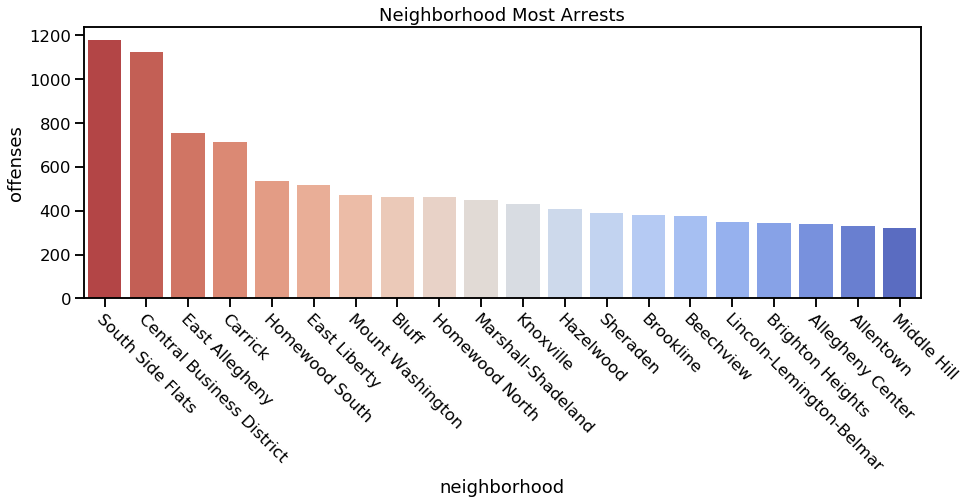

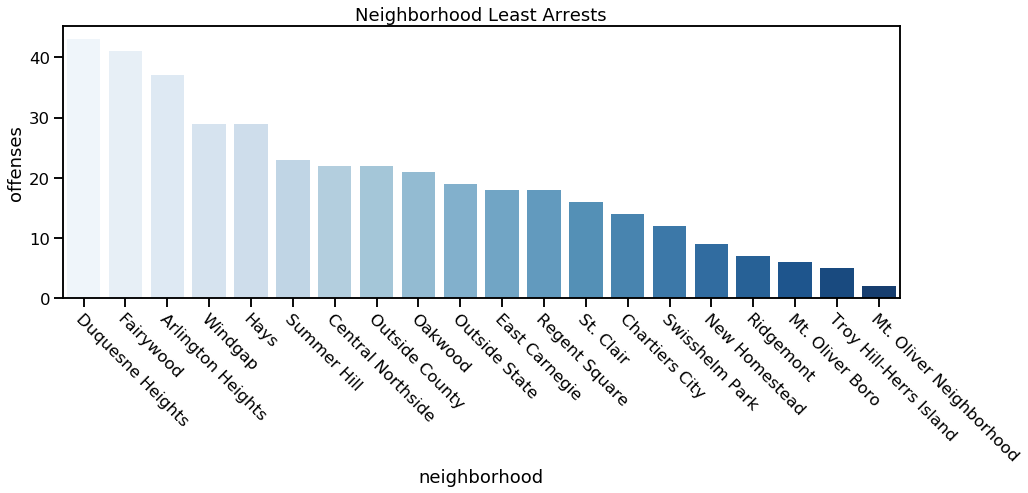

In [14]:
sns.set_context('talk')
arrests_neigh = arrests.groupby(['neighborhood'], as_index=False).agg({'offenses': 'count'})
arrests_neigh.sort_values(by='offenses', ascending=False, inplace=True)
arrests_plot = {
    'Neighborhood Most Arrests': arrests_neigh.head(20),
    'Neighborhood Least Arrests': arrests_neigh.tail(20)
}
colors = ['coolwarm_r', 'Blues']
counter = 0
for name, df in arrests_plot.items():
    plt.figure(figsize=(15, 5))
    sns.barplot(x='neighborhood', y='offenses', data=df, palette=colors[counter])
    plt.xticks(rotation=-45, ha='left',  rotation_mode='anchor')
    plt.title(name)
    counter += 1
plt.show()

### Data Visualization (continued)
#### Price per Neighborhood


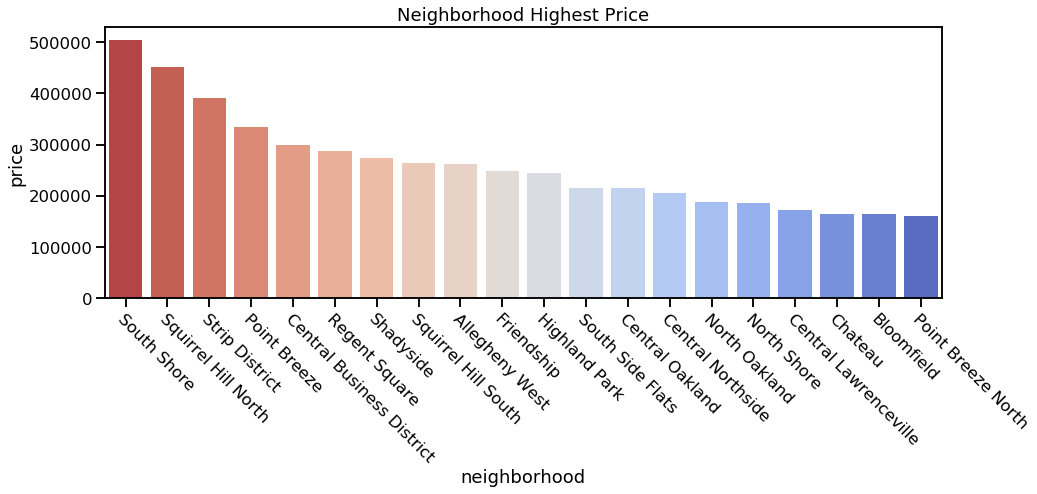

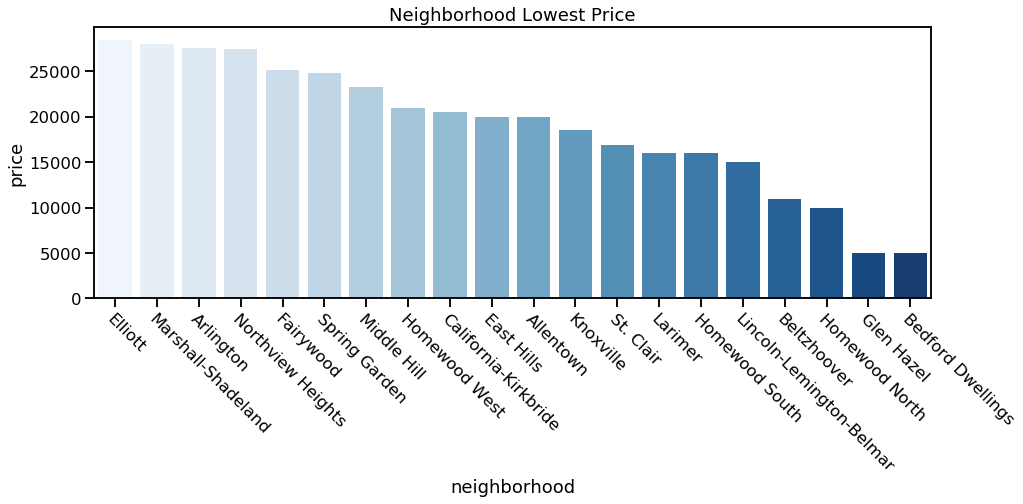

In [15]:
sales_neigh = pgh_sales.groupby(['neighborhood'], as_index=False).agg({'price': 'median'})
sales_neigh.sort_values(by='price', ascending=False, inplace=True)
sales_plot = {
    'Neighborhood Highest Price': sales_neigh.head(20),
    'Neighborhood Lowest Price': sales_neigh.tail(20)
}
colors = ['coolwarm_r', 'Blues']
counter = 0
for name, df in sales_plot.items():
    plt.figure(figsize=(15, 5))
    sns.barplot(x='neighborhood', y='price', data=df, palette=colors[counter])
    plt.xticks(rotation=-45, ha='left',  rotation_mode='anchor')
    plt.title(name)
    counter += 1
plt.show()

In [16]:
city_median = pgh_time_medians.iloc[:, 1:].median()

### Median Price Over Time

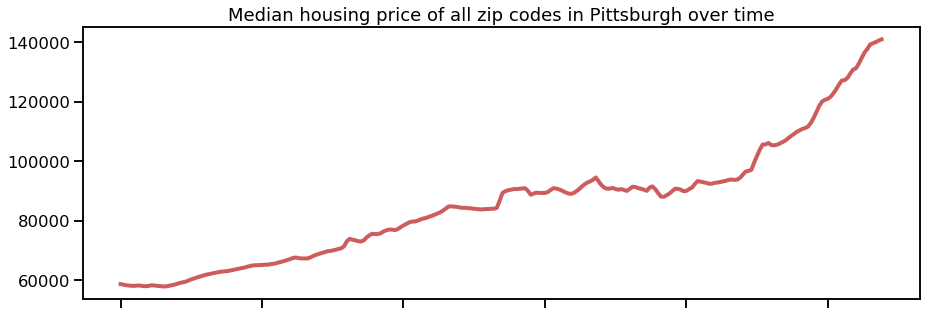

In [17]:
plt.figure(figsize=(15, 5))
city_median.plot(linewidth=4, color='indianred')
plt.title('Median housing price of all zip codes in Pittsburgh over time')
plt.show()

### Distribution of Price

#### Pittsburgh Real Estate Affordability Visualized

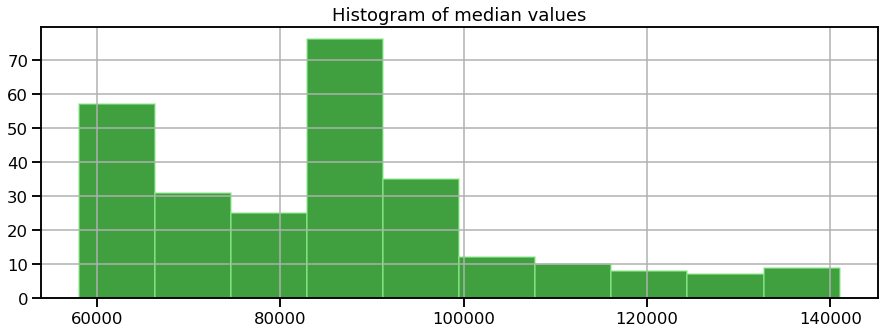

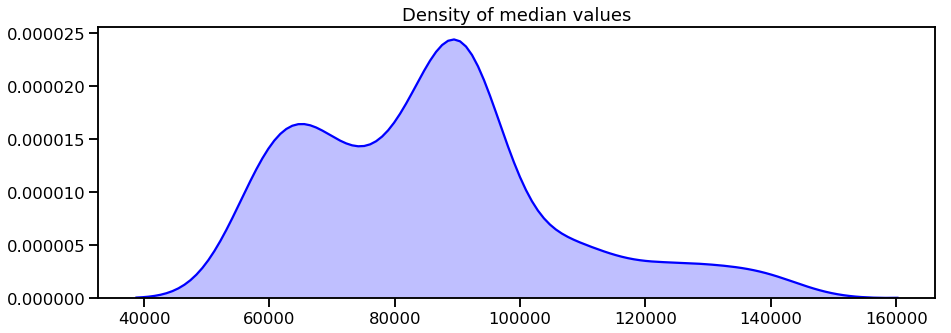

In [18]:
city_median.index = pd.to_datetime(city_median.index)
city_median.hist(figsize=(15, 5), color='g', alpha=.75, ec='lightgreen')
plt.title('Histogram of median values')
plt.show()
plt.figure(figsize=(15, 5))
sns.kdeplot(city_median, color='b', shade=True)
plt.title('Density of median values')
plt.show()

In [19]:
pgh_time_series = pgh_time_medians.copy()
pgh_time_series.rename(columns={'zip_code': 'ds'}, inplace=True)
pgh_time_series = pgh_time_series.set_index('ds').T
pgh_time_series.index = pd.to_datetime(pgh_time_series.index)

### Price by Zip Code

(There's a reason this graph is backward.)

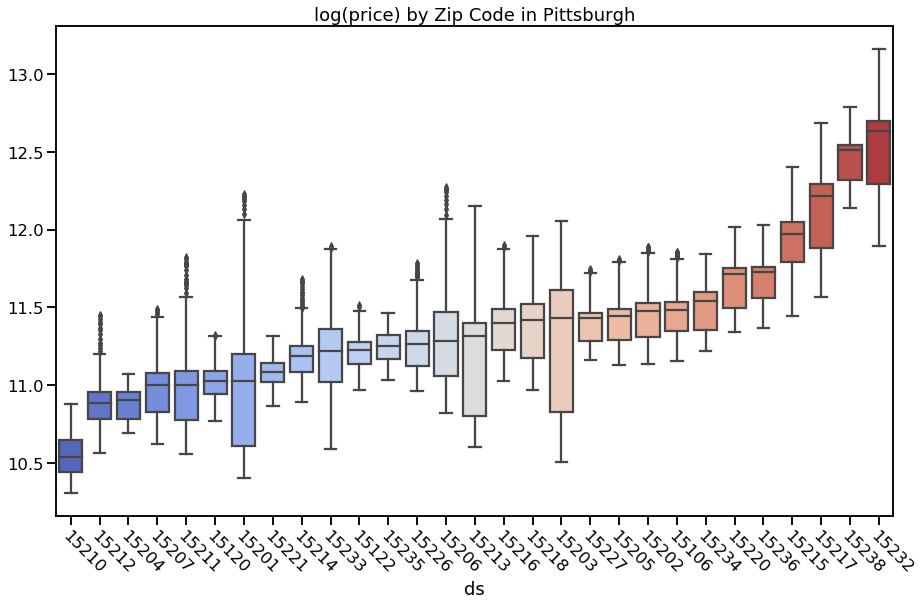

In [20]:
box_set = pgh_time_series.reset_index(drop=True)
plt.figure(figsize=(15, 9))
sns.boxplot(data=np.log(box_set), order=box_set.median().sort_values(ascending=True).index, palette='coolwarm')
plt.xticks(rotation=-45, ha='left', rotation_mode='anchor')
plt.title('log(price) by Zip Code in Pittsburgh')
plt.show()

### Foreclosure Total and Foreclosure Price by Zip Code

(Here's why that price graph is reversed.)

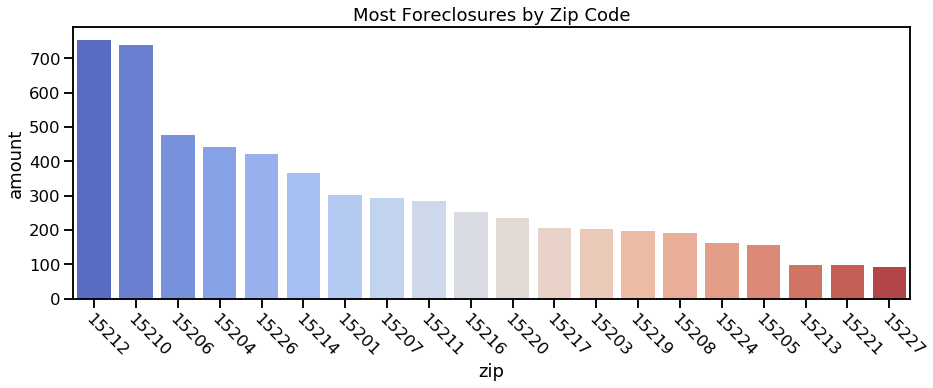

In [21]:
foreclosures = foreclosures.rename(index=str,columns={'pin':'PARID'})
foreclosures = foreclosures[['PARID', 'municipality', 'amount', 'filing_date']]
assess = assess[['PARID', 'PROPERTYZIP']]
foreclosures = pd.merge(foreclosures, assess, on='PARID', how='left')
foreclosures = foreclosures.dropna()
foreclosures.PROPERTYZIP = foreclosures.PROPERTYZIP.astype(int)
foreclosures = foreclosures.rename(index=str,columns={'PROPERTYZIP':'zip'})
fore_pitts = foreclosures.loc[foreclosures['municipality'] == 'Pittsburgh']
fore_zip_count = fore_pitts.groupby(['zip'], as_index=False).agg({'amount': 'count'})
fore_zip_count = fore_zip_count.sort_values(by='amount', ascending=False)
plt.figure(figsize=(15, 5))
sns.barplot(x='zip', y='amount', data=fore_zip_count.head(20), order=fore_zip_count.head(20)['zip'], palette = 'coolwarm')
plt.xticks(rotation=-45, ha='left',  rotation_mode='anchor')
plt.title("Most Foreclosures by Zip Code")
plt.show()

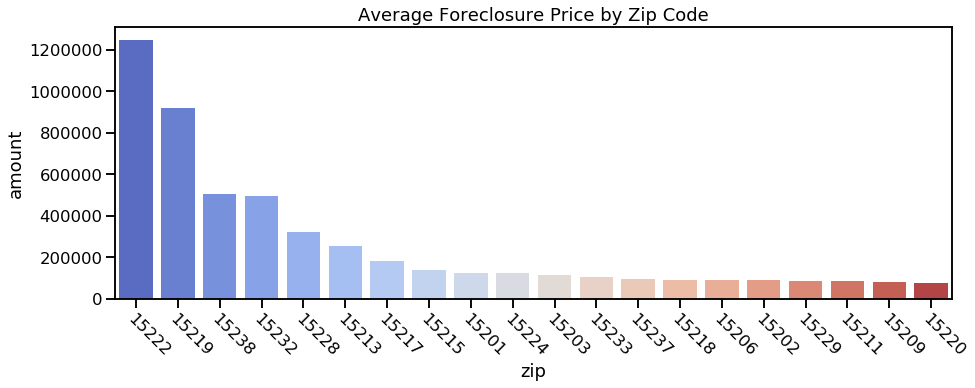

In [22]:
fore_zip = fore_pitts.groupby(['zip'], as_index=False).agg({'amount': 'mean'})
fore_zip = fore_zip.sort_values(by='amount', ascending=False)
plt.figure(figsize=(15, 5))
sns.barplot(x='zip', y='amount',data=fore_zip.head(20), order=fore_zip.head(20)['zip'], palette = 'coolwarm')
plt.xticks(rotation=-45, ha='left',  rotation_mode='anchor')
plt.title("Average Foreclosure Price by Zip Code")
plt.show()

### Time-Series Analysis of Foreclosures
#### Discovering Foreclosure Trends

Facebook Prophet model and trends visualization.

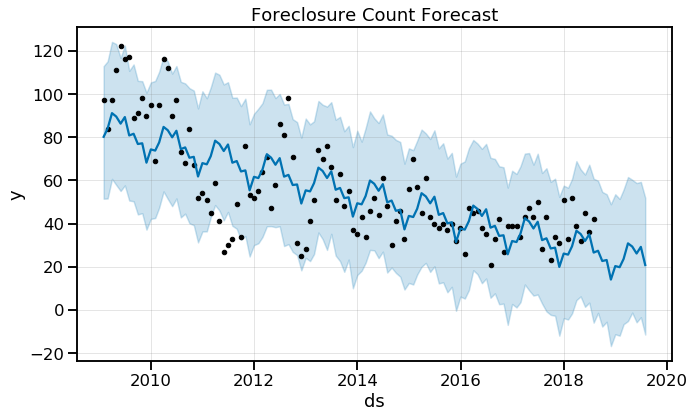

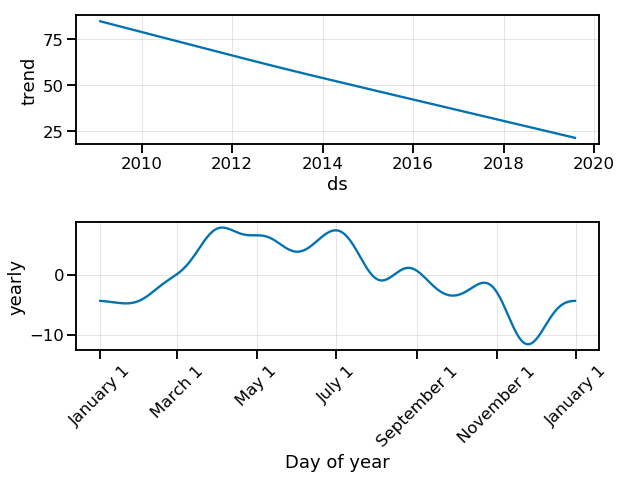

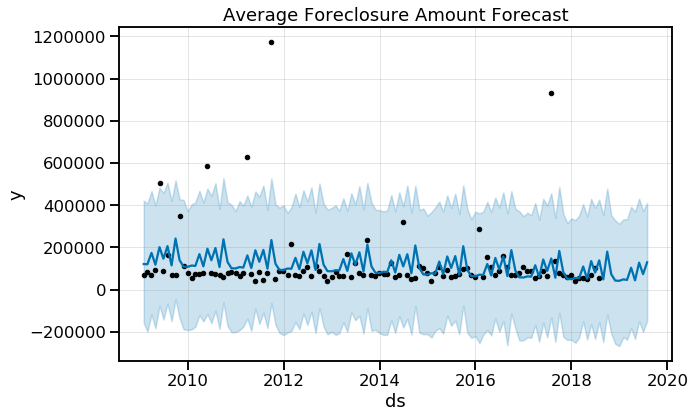

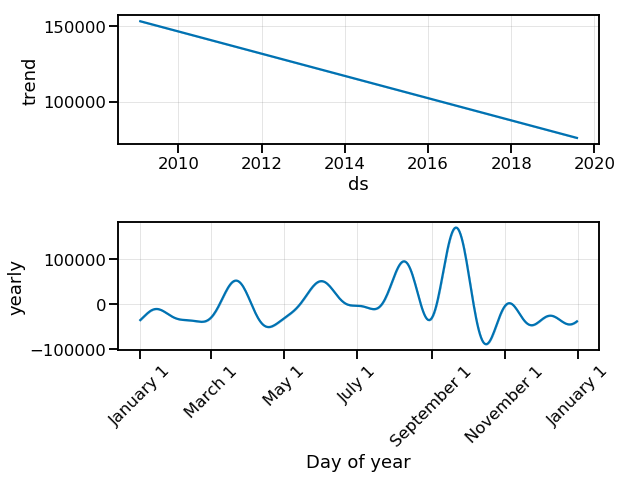

In [23]:
fore_pitts.filing_date = fore_pitts.filing_date.astype('datetime64[ns]')
fore_proph = fore_pitts
fore_proph.index = fore_proph['filing_date']
fore_proph = fore_proph.drop(['PARID', 'municipality', 'zip', 'filing_date'], axis=1)
del fore_proph.index.name
fore_count = fore_proph.resample('M').count()
fore_count['ds'] = fore_count.index
fore_count = fore_count.rename(index=str, columns={'amount':'y'})
fore_mean = fore_proph.resample('M').mean()
fore_mean['ds'] = fore_mean.index
fore_mean = fore_mean.rename(index=str, columns={'amount':'y'})
names = ["Foreclosure Count Forecast", "Average Foreclosure Amount Forecast"]
for i, df in enumerate([fore_count, fore_mean]):
    model = Prophet(interval_width=0.95, weekly_seasonality=False, daily_seasonality=False)
    model.fit(df)
    pred_dates = model.make_future_dataframe(periods=12, freq='M')
    pred = model.predict(pred_dates)
    model.plot(pred, uncertainty=True)
    plt.title(names[i])
    model.plot_components(pred)
    plt.xticks(rotation=45)

### Time-Series Analysis of Median Price 
#### Median Price by  Zip Code

Achieving stationarity by differencing.
Predicting median price and predicted price by Prophet model.

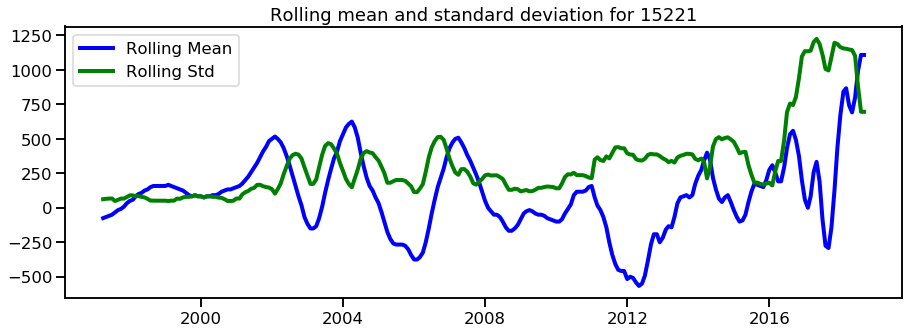

'Test results for zip 15221'

Test Statistic       -4.044854
p-value               0.001193
Critical Value 1%    -3.456155
Critical Value 5%    -2.872897
Critical Value 10%   -2.572822
dtype: float64

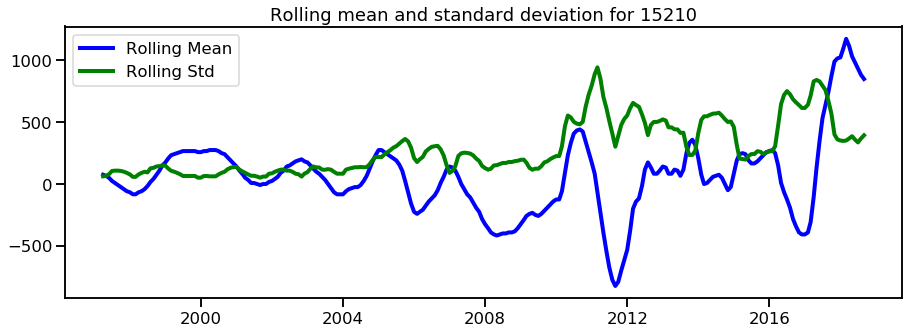

'Test results for zip 15210'

Test Statistic       -4.384561
p-value               0.000316
Critical Value 1%    -3.455461
Critical Value 5%    -2.872593
Critical Value 10%   -2.572660
dtype: float64

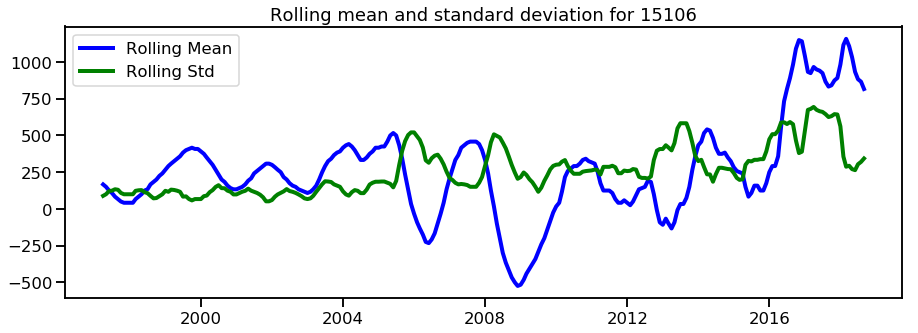

'Test results for zip 15106'

Test Statistic       -3.928295
p-value               0.001836
Critical Value 1%    -3.455175
Critical Value 5%    -2.872468
Critical Value 10%   -2.572593
dtype: float64

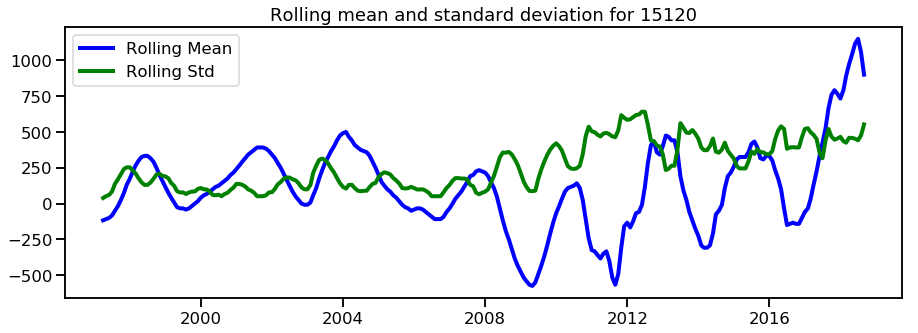

'Test results for zip 15120'

Test Statistic       -5.358437
p-value               0.000004
Critical Value 1%    -3.455953
Critical Value 5%    -2.872809
Critical Value 10%   -2.572775
dtype: float64

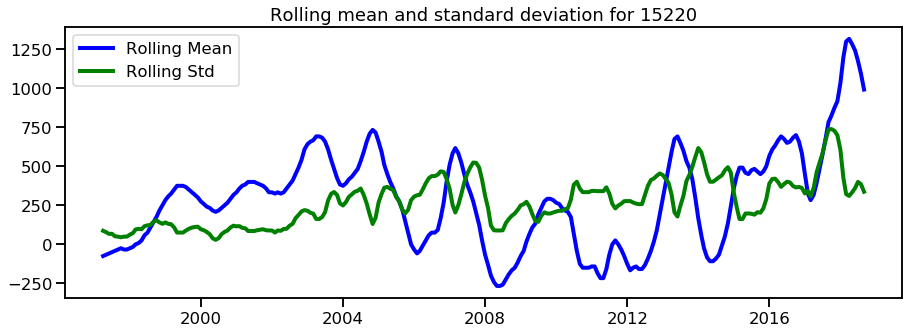

'Test results for zip 15220'

Test Statistic       -4.137556
p-value               0.000839
Critical Value 1%    -3.455270
Critical Value 5%    -2.872509
Critical Value 10%   -2.572615
dtype: float64

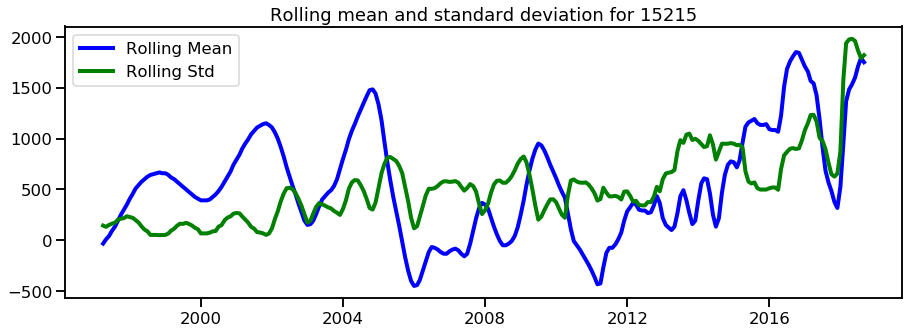

'Test results for zip 15215'

Test Statistic       -5.353022
p-value               0.000004
Critical Value 1%    -3.455270
Critical Value 5%    -2.872509
Critical Value 10%   -2.572615
dtype: float64

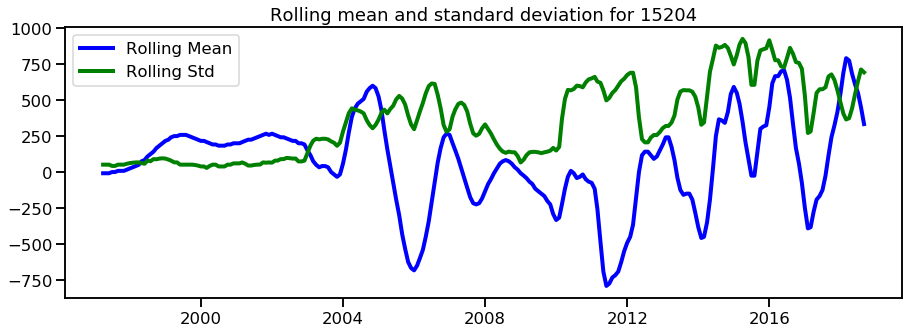

'Test results for zip 15204'

Test Statistic       -4.036288
p-value               0.001232
Critical Value 1%    -3.456155
Critical Value 5%    -2.872897
Critical Value 10%   -2.572822
dtype: float64

In [24]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(name: str, timeseries: pd.Series): 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    return(dfoutput)

def plot_time_series(name, time_series):
    plt.figure(figsize=(15, 5))
    rolmean = time_series.rolling(12).mean()
    rolstd = time_series.rolling(12).std()
    mean = plt.plot(rolmean, color='b', label='Rolling Mean', linewidth=4)
    std = plt.plot(rolstd, color='g', label='Rolling Std', linewidth=4)
    plt.legend(loc='best')
    plt.title(f'Rolling mean and standard deviation for {name}')
    plt.show()

sta_series = {}
series_orig = {}
for series in pgh_time_series.iteritems():
    temp_series = series[1].diff()
    temp_series.dropna(inplace=True)
    name = series[0]
    results = test_stationarity(name, temp_series)
    if results[0] < results[2] and results[1] < .05:
        series_orig[name] = series[1]
        sta_series[name] = temp_series
        plot_time_series(name, temp_series)
        display(f'Test results for zip {name}', results)

## Time-Series (continued)
### Auto-correlation and partial auto-correlation

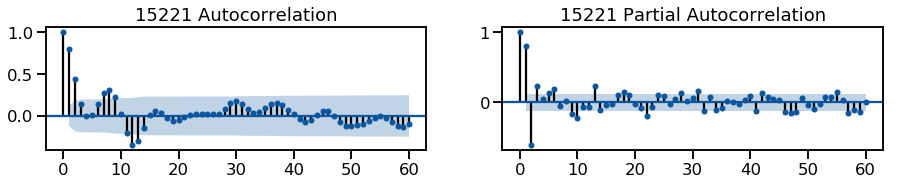

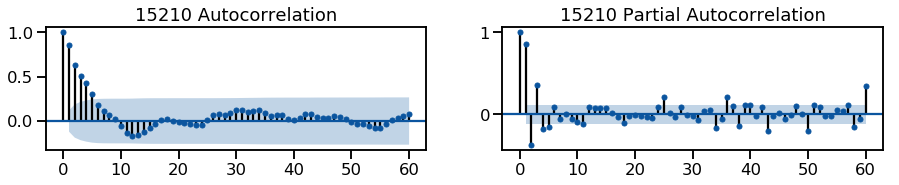

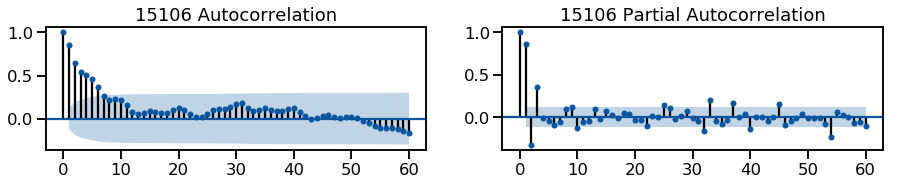

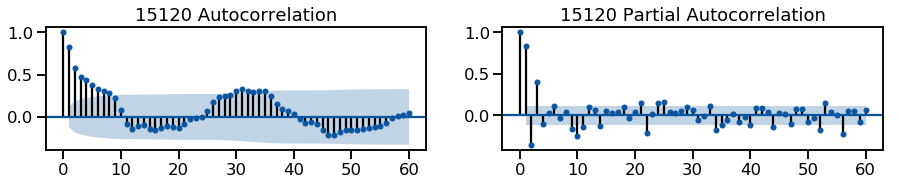

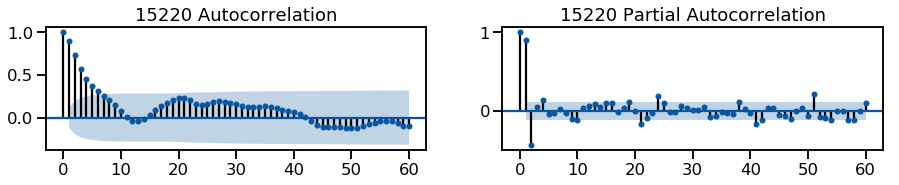

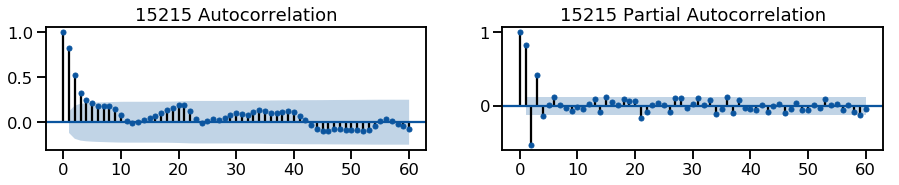

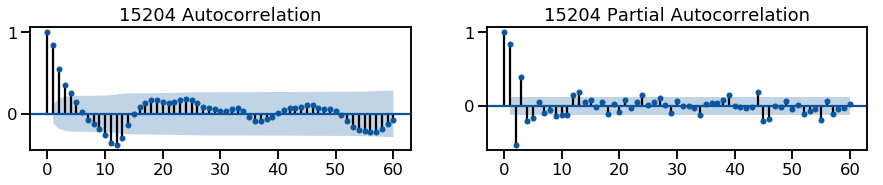

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set_context('talk')
sns.set_palette('Blues_r')
for name, df in sta_series.items():
    plt.figure(figsize=(15, 5))
    plt.subplot(221); plot_acf(df, lags=60, ax=plt.gca(), title=f'{name} Autocorrelation')
    plt.subplot(222); plot_pacf(df,  lags=60, ax=plt.gca(), title=f'{name} Partial Autocorrelation')


## Forecasting
### Facebook Prophet Forecasts

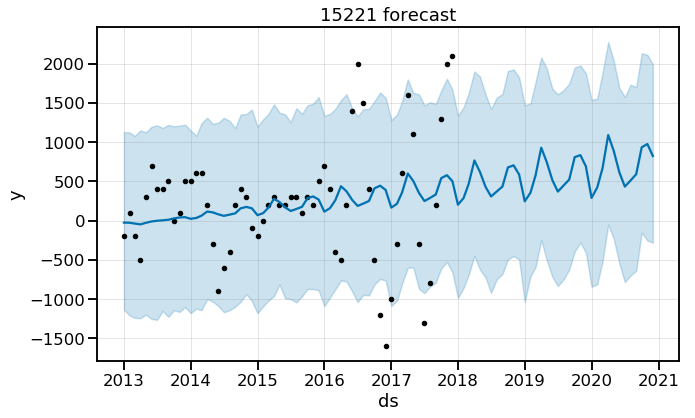

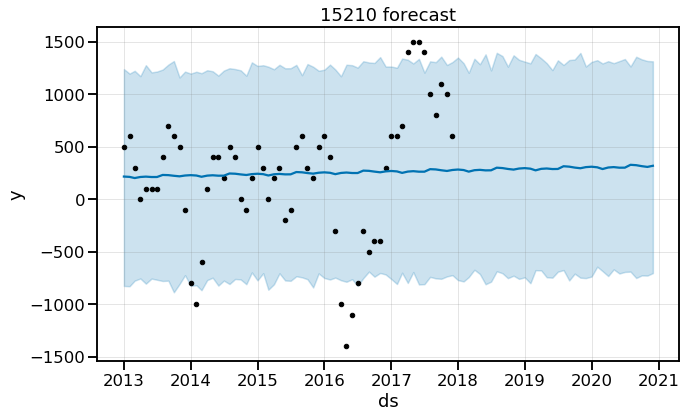

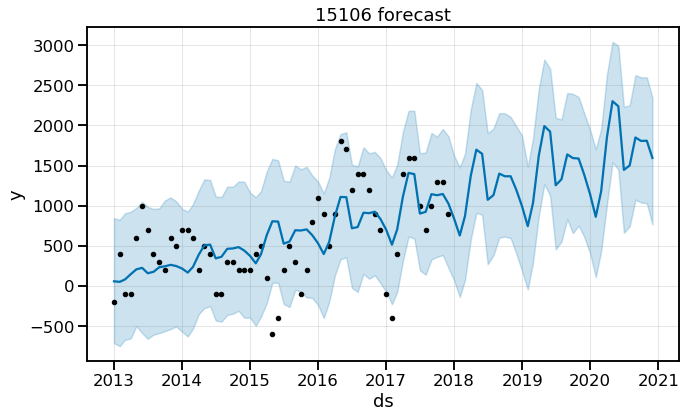

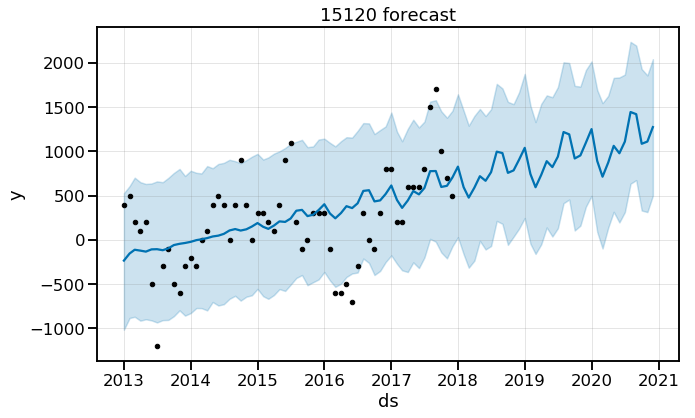

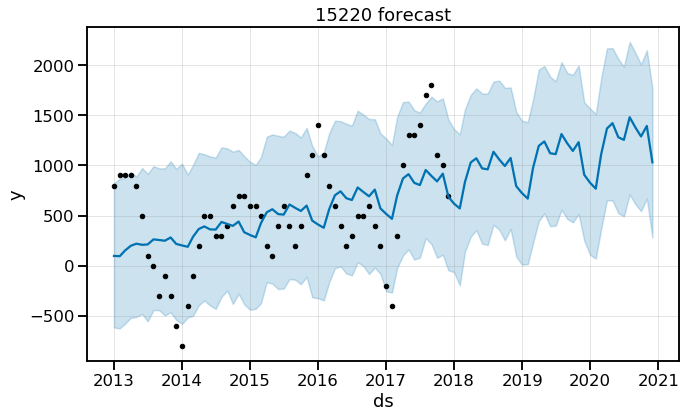

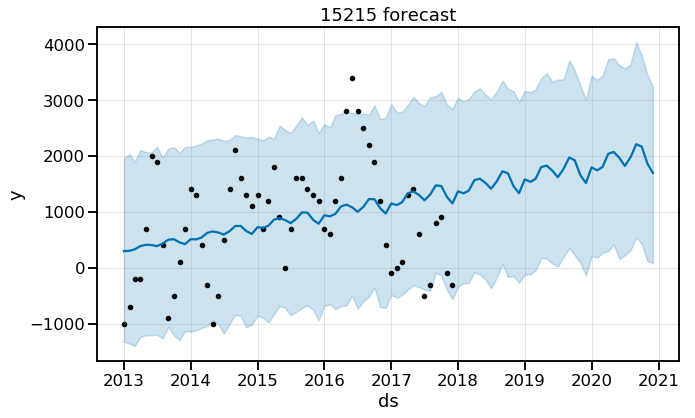

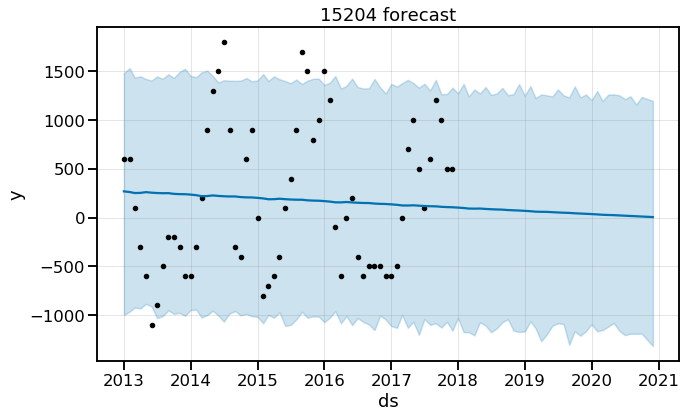

In [26]:
forecasts = {}
for name, df in sta_series.items():
    name = f'{name} forecast'
    temp = pd.DataFrame(df['2013':'2017'])
    temp.reset_index(inplace=True)
    temp.columns = ['ds', 'y']
    prophet_model = Prophet(
        interval_width=0.9, 
        weekly_seasonality=False, 
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    prophet_model.fit(temp)
    future = prophet_model.make_future_dataframe(periods=12*3, freq='M')
    forecast = prophet_model.predict(future)
    forecasts[name] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    prophet_model.plot(forecast)
    plt.title(name)
    plt.show()

## Forecasting (continued)
### Prophet prediction with error

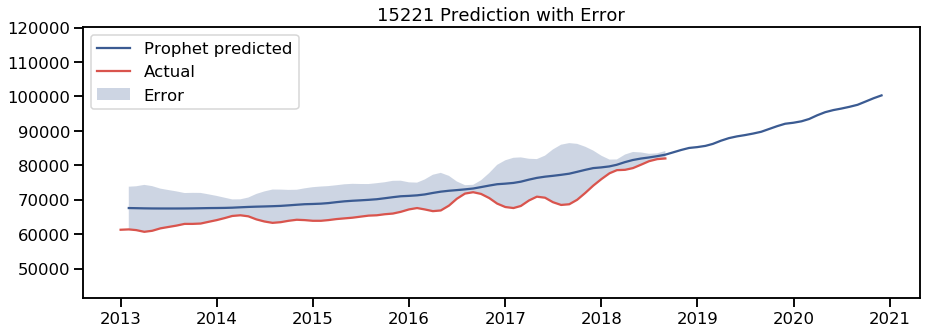

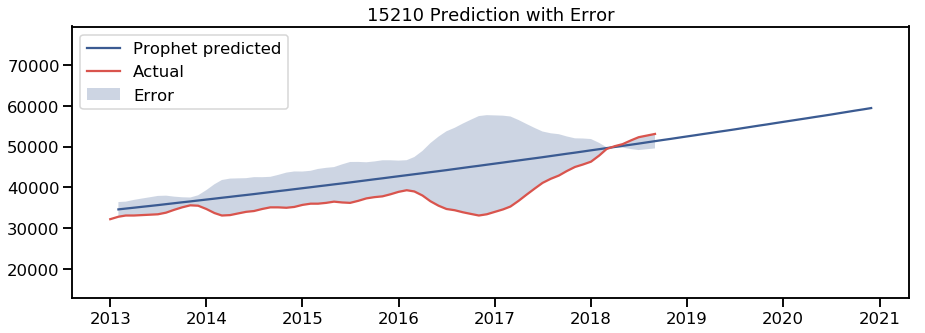

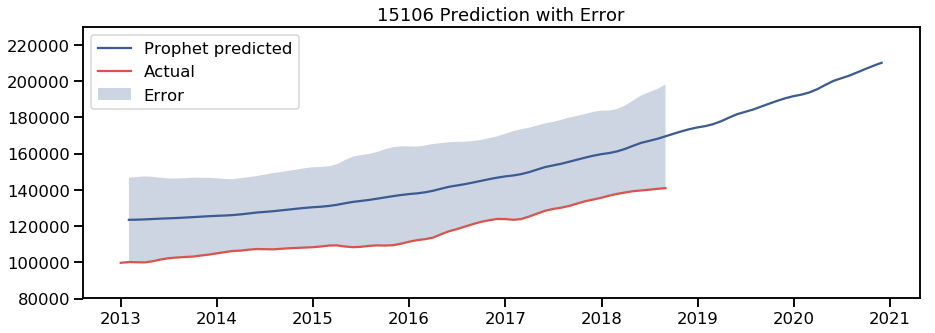

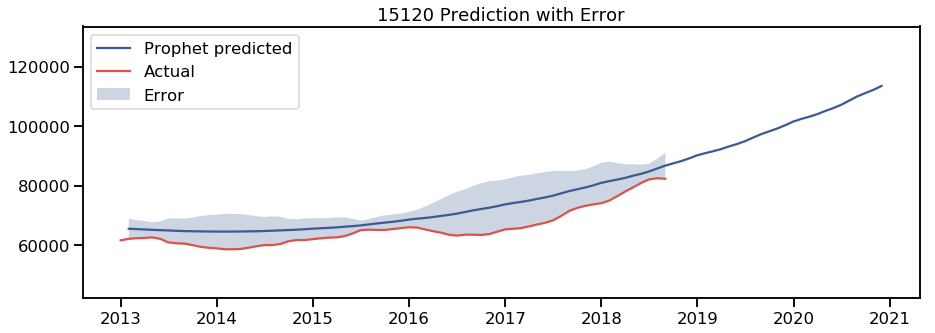

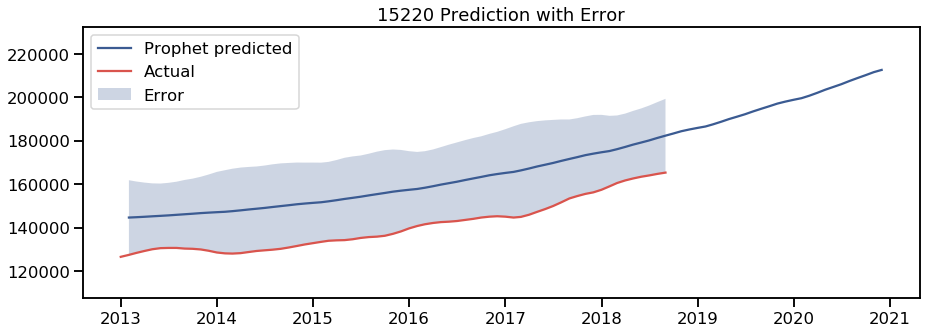

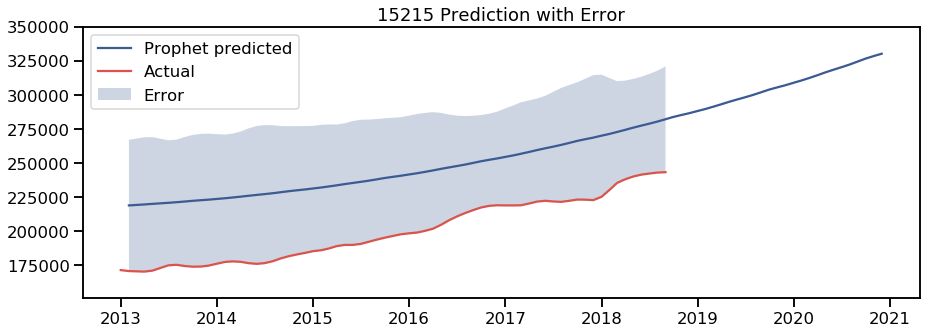

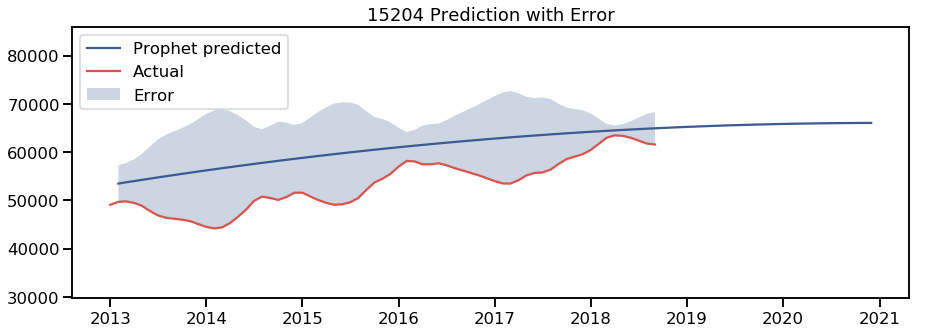

In [27]:
colors = ['denim blue', 'pale red']
sns.set_palette(sns.xkcd_palette(colors))
deltas = {}
for name, df in series_orig.items():
    temp_2018 = df.iloc[-20:]

    forecast = forecasts[f'{name} forecast']
    _pred = forecast.loc[forecast.ds > '2013']
    _pred = _pred.loc[_pred.ds < '2021']
    prophet_predict = np.r_[
        temp_2018.iloc[0],
        _pred.yhat.iloc[1:]
    ].cumsum()
    error = np.abs(df['2013-02-01':] - prophet_predict[:68])
    delta = prophet_predict[-1] - temp_2018[-1]
    deltas[name] = {
        'delta': delta,
        'orig': temp_2018[-1],
        'pred': prophet_predict[-1],
        'error': np.median(error),
        'delta_minus_error': delta - np.median(error),
        'median_price_2018': temp_2018.median()
    }
    plt.figure(figsize=(15, 5))
    plt.plot(_pred.ds, prophet_predict, label='Prophet predicted')
    plt.plot(df['2013':], label='Actual')
    x = pd.to_datetime(df['2013-02-01':].index)
    y = prophet_predict[:68]
    plt.fill_between(
        x, 
        y+error,
        y-error, 
        alpha=0.25,
        label='Error'
    )
    plt.title(f'{name} Prediction with Error')
    plt.legend(loc='upper left')
    plt.ylim(bottom=(y[0]-error[0])-20000, top=np.max(prophet_predict)+20000)

## Early Recommendation
### Zip codes projected to have a large change in value

Accounting for error rate, which zip codes offer the largest percentage increase by Prophet model.

In [28]:
investment_zips = pd.DataFrame(deltas).T
investment_zips.assign(
    pct_delta=lambda x: (x['delta_minus_error'] / x['median_price_2018']) * 100
).sort_values(by='pct_delta', ascending=False)

,delta,delta_minus_error,error,median_price_2018,orig,pred,pct_delta
15120,31243.340393,26554.241412,4689.098981,73450.0,82300.0,113543.340393,36.152813
15106,69165.113448,45511.812681,23653.300767,134250.0,141000.0,210165.113448,33.900792
15215,86966.861417,42621.480718,44345.380698,223050.0,243200.0,330166.861417,19.108487
15221,18304.038383,13673.907775,4630.130609,73050.0,82000.0,100304.038383,18.718560
15220,47304.587519,28862.208465,18442.379054,155850.0,165300.0,212604.587519,18.519223
15210,6346.515477,2148.051741,4198.463736,45300.0,53100.0,59446.515477,4.741836
15204,4474.241954,-2790.379584,7264.621538,59350.0,61600.0,66074.241954,-4.701566


In [29]:
import re
pgh_sales_demo = pgh_sales.merge(demographics)
zip_median = pgh_sales_demo.groupby('zip_code', as_index=False).agg({'price': 'median'})
zip_median.rename(columns={'price': 'zip_median_price'}, inplace=True)
pgh_sales_demo = pgh_sales_demo.merge(zip_median)
arrest_counts = arrests.groupby('zip_code', as_index=False).agg({'offenses': 'count'})
arrest_counts.rename(columns={'offenses': 'total_arrests'}, inplace=True)
whole_enchilada = pgh_sales_demo.merge(arrest_counts)
nums = ['white_pct', 'black_pct', 'median_income']
for num in nums: whole_enchilada[num] = pd.to_numeric(whole_enchilada[num]);
whole_enchilada['saledate'] = pd.to_datetime(whole_enchilada['saledate'])
whole_enchilada.street_address = whole_enchilada.street_address.apply(lambda x: re.sub(' +', ' ', x))
whole_enchilada.dropna(inplace=True)
whole_enchilada.drop(whole_enchilada.loc[whole_enchilada.price == whole_enchilada.price.max()].index, inplace=True)

In [30]:
def impute_median(x):
    if x['price'] < 1000:
        x['price'] = x['zip_median_price']
    return x
whole_enchilada = whole_enchilada.apply(impute_median, axis=1)

In [31]:
whole_enchilada = whole_enchilada.loc[whole_enchilada.zip_code.isin(list(investment_zips.index.astype(str)))]

In [32]:
"""
Ran for five or six days and got a lot of data. 
Don't run because it calls Zillow's live api.
"""
# from zillow_call import DataIO
# data_io = DataIO()
# todo_bueno = data_io.call_zillow(whole_enchilada, True)
# final_set = todo_bueno.merge(whole_enchilada, on='parid', how='left')

"\nRan for five or six days and got a lot of data. \nDon't run because it calls Zillow's live api.\n"

In [33]:
"""
This one instead.
"""
final_set = pd.read_csv('data/final_set.csv')

In [34]:
aggregate_attributes = ['zip_median_price', 'total_arrests', 'mean_income', 
                        'median_income', 'black_pct', 'white_pct', 'pop']
cat_attributes = ['street_address', 'neighborhood', 'zip_code', 'year_built']
ind_num_attributes = ['age', 'baths', 'beds', 'lot_size', 'sqft', 'price']
all_num_attributes = aggregate_attributes + ind_num_attributes
final_set[all_num_attributes] = final_set[all_num_attributes].astype('float')
final_set.drop(final_set.loc[final_set.price == final_set.price.max()].index, inplace=True)
final_set.drop(final_set.loc[final_set.sqft <= 300].index, inplace=True)
final_set.drop_duplicates(inplace=True)
way_out_age = final_set.loc[final_set.age == final_set.age.max()]
way_out_age.age = 119
way_out_age.year_built = '1900'
final_set.loc[final_set.age == final_set.age.max()] = way_out_age
final_set.drop(final_set.loc[final_set.baths == final_set.baths.max()].index, inplace=True)
final_set.drop(final_set.loc[final_set.beds == final_set.beds.max()].index, inplace=True)
final_set.drop(final_set.loc[final_set.sqft == final_set.sqft.max()].index, inplace=True)
final_set.drop(final_set.loc[final_set.street_address.str.contains('5321 5TH AVE')].index, inplace=True)

In [35]:
import copy
pd.options.display.float_format = '{:,.2f}'.format
max_to_med = copy.copy(ind_num_attributes)
max_to_med.remove('price')
for var in max_to_med:
    series_median = int(round(final_set[var].median()))
    final_set.loc[final_set[var] == final_set[var].max(), var] = series_median
    final_set.loc[final_set[var].isna(), var] = series_median

In [36]:
final_set.baths = np.ceil(final_set.baths)
final_set.loc[final_set.sqft > 12000, 'sqft'] = final_set.sqft.median()
final_set.loc[final_set.lot_size >= final_set.lot_size.median() + (2 * final_set.lot_size.std()), 'lot_size'] = final_set.lot_size.median()
final_set.loc[final_set.lot_size == final_set.lot_size.max(), 'lot_size'] = final_set.lot_size.median()

In [37]:
from datetime import datetime
now = datetime.now()
final_set.loc[final_set.year_built.isna(), 'year_built'] = f'{now.year - final_set.age.median()}'

## Demographics and Individual House Attributes
### Drilling down into zip codes and neighborhoods

Which attributes contribute to property value?

Feature selection by correlation.

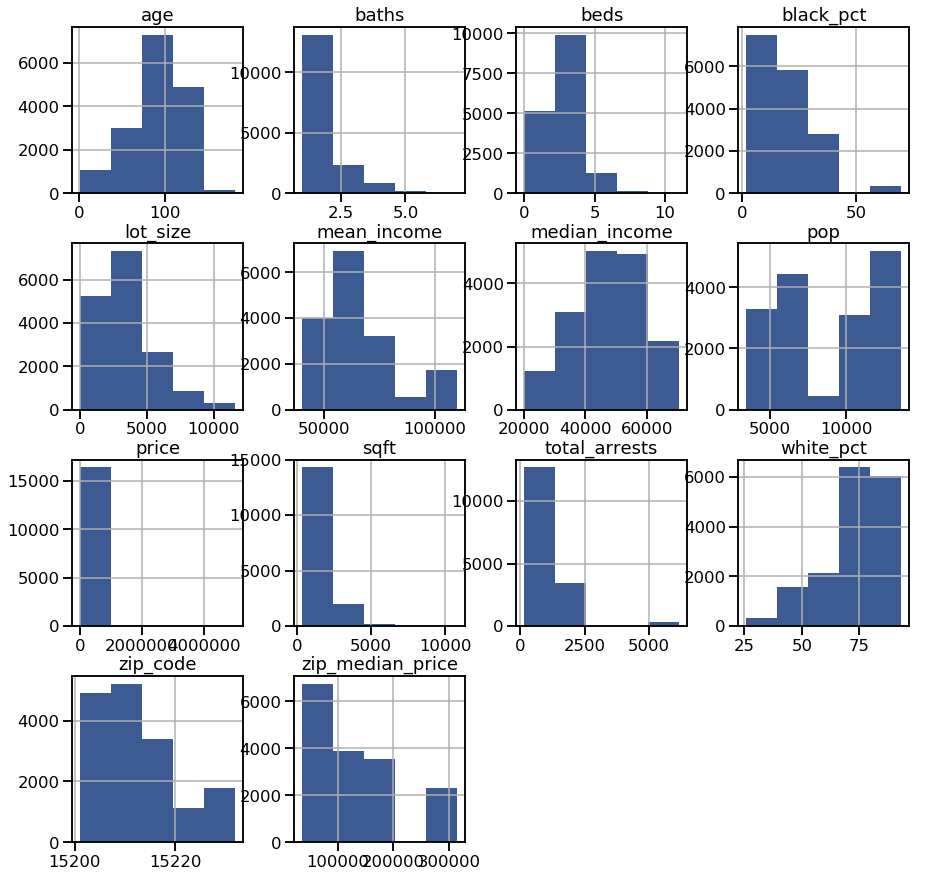

In [38]:
final_set.hist(bins=5, figsize=(15, 15))
plt.show()

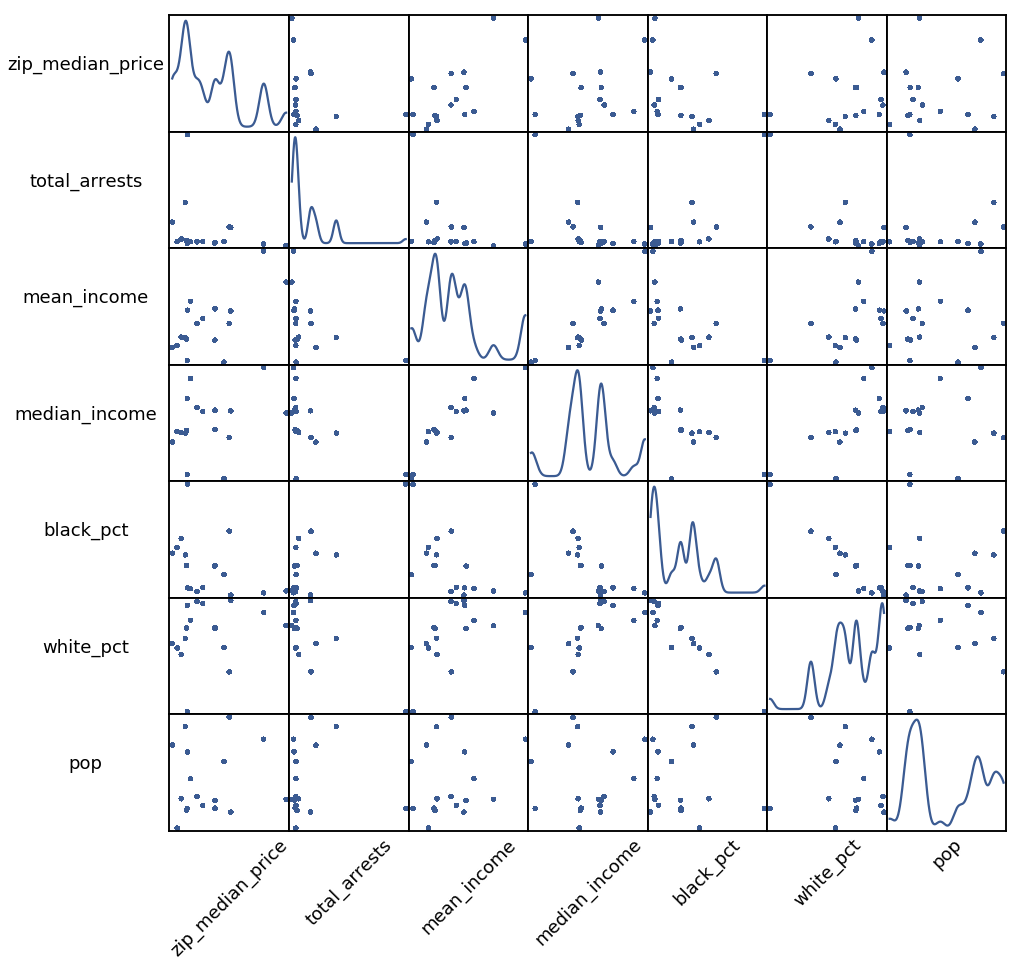

In [39]:
from pandas.plotting import scatter_matrix
sm = scatter_matrix(final_set[aggregate_attributes], figsize=(15, 15), diagonal='kde', alpha=.65)
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.get_yaxis().set_label_coords(-.7, 0.5) for s in sm.reshape(-1)]
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]
plt.show()

In [40]:
housing = final_set.drop('price', axis=1)
housing_label = final_set.price.copy()

### Demographics and Individual House Attributes (continued)

Offers feature selection for regression.

price               1.00
baths               0.56
zip_median_price    0.54
sqft                0.52
mean_income         0.40
beds                0.26
median_income       0.22
lot_size            0.12
white_pct           0.10
pop                 0.08
age                -0.17
total_arrests      -0.18
black_pct          -0.22
Name: price, dtype: float64

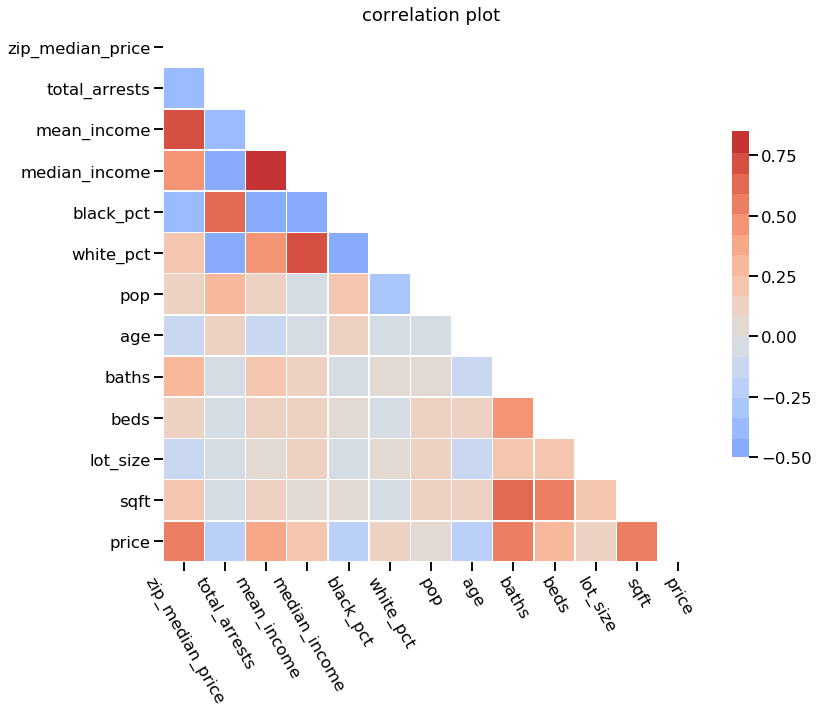

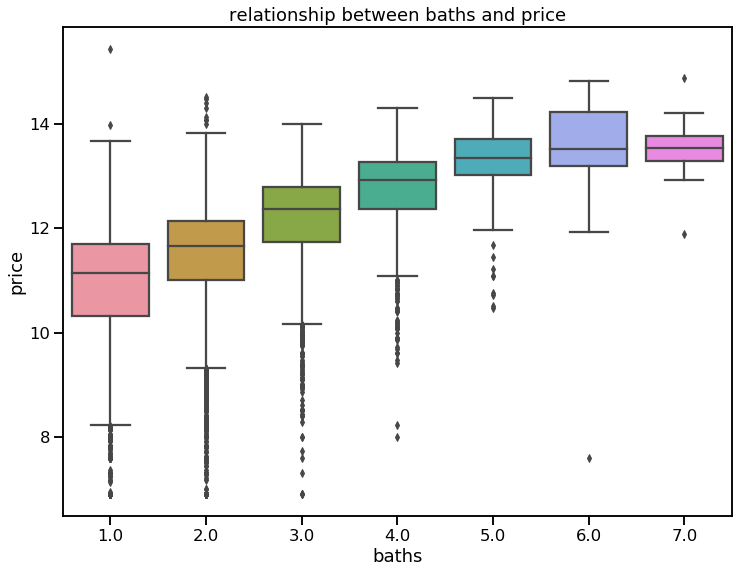

In [41]:
corr_matrix = final_set[all_num_attributes].corr()
display(corr_matrix['price'].sort_values(ascending=False))
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.color_palette('coolwarm', 20)
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.85, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=-60)
plt.yticks(rotation=0)
plt.title('correlation plot')
plt.show()
plt.figure(figsize=(12, 9))
sns.boxplot(x=final_set.baths, y=np.log(final_set.price))
plt.yticks(rotation=0)
plt.title('relationship between baths and price')
plt.show()

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Imputer

In [43]:
from sklearn.model_selection import train_test_split
train_feats, test_feats, train_label, test_label = train_test_split(housing, housing_label, random_state=1234)

In [44]:
num_atts = ['baths', 'zip_median_price', 'sqft', 'age']
cat_atts = ['neighborhood']
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])
pipeline =  ColumnTransformer([
    ('num', num_pipeline, num_atts),
    ('cat', OneHotEncoder(), cat_atts),
])
train_feats[cat_atts] = train_feats[cat_atts].astype(str)
test_feats[cat_atts] = test_feats[cat_atts].astype(str)

In [45]:
train_feats = train_feats.reset_index()
test_feats = test_feats.reset_index()
house_train_prepared = pipeline.fit_transform(train_feats)

## Prediction
### Using demographics, individual house attributes, and neighborhood attributes

* Can we predict the price of an individual house?
* What is the error interval for each model?
* How much processor time is involved?

In [46]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lin_reg = LinearRegression()
lin_reg.fit(house_train_prepared, train_label)
test_prepped = pipeline.transform(test_feats)
reg_pred = lin_reg.predict(test_prepped)
reg_rmse = np.sqrt(mean_squared_error(test_label, reg_pred))
print('Linear Regression RMSE:', round(reg_rmse, 2))

Linear Regression RMSE: 122533.21
CPU times: user 402 ms, sys: 58.4 ms, total: 460 ms
Wall time: 205 ms


In [47]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
forest_reg = RandomForestRegressor()
param_grid = [
    {'n_estimators': [100, 250, 300], 'max_features': [12, 24, 30]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(house_train_prepared, train_label)
display(grid_search.best_params_)
display(grid_search.best_estimator_)
print('Random Forest training RMSE:', round(np.sqrt(-grid_search.cv_results_['mean_test_score'].min()), 2))

{'max_features': 12, 'n_estimators': 250}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

Random Forest training RMSE: 98849.83
CPU times: user 32.6 s, sys: 887 ms, total: 33.4 s
Wall time: 5min 15s


In [48]:
%%time
from sklearn.metrics import mean_squared_error
final_model = grid_search.best_estimator_
final_preds = final_model.predict(test_prepped)
rf_rmse = np.sqrt(mean_squared_error(test_label, final_preds))
print('Random Forest test RMSE:', round(rf_rmse, 2))

Random Forest test RMSE: 118400.57
CPU times: user 503 ms, sys: 40.3 ms, total: 543 ms
Wall time: 544 ms


# Work Still To Do

## Ensemble

Since the root mean squared errors of the two regressors are not great. And since they overfit a little with the training data, they're good candidates for ensemble methods: using their output as the input of another model.

## Neural Nets

Training a TensorFlow / Keras neural network as a regressor might also yield better results.


